In [3]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import T5Tokenizer, T5ForConditionalGeneration



In [4]:
from datasets import load_dataset
import torch
from tqdm import tqdm

wiki = load_dataset("wikitext", "wikitext-2-raw-v1")

train = wiki['train']['text'][:1000]
test = wiki['test']['text'][:100]
val = wiki['validation']['text'][:100]

In [5]:
import re
# train 0-51 是第一个名词解释
# 大标题存一个，小标题存一个
def PreprocessTitle(dataset):
    filter_set = list(filter(lambda element: element != '', dataset))
    title_position = 0
    dealt_set = []
    title_content = ""
    for i,j in enumerate(filter_set):
        pattern_s = re.compile(r'@\W@')
        s_flag = pattern_s.search(j)
        if s_flag:
          filter_set[i] = re.sub(r' @(\W)@ ',r'\1',filter_set[i])
        pattern = re.compile(r'^ = .+ = \n$')
        result = pattern.match(j)
        if result:
            final_string = ""
            for k in range(title_position,i):
                if k == title_position:
                    pattern2 = re.compile(r'^ = = .+ = = \n$')
                    result2 = pattern2.match(filter_set[k])
                    #如果是两个=起步，说明是小标题，需要加上大标题，如果不是两个，那就是大标题普通处理
                    if result2:
                        temp = re.sub(r' (\w)', f'{title_content}\\1', filter_set[k],count=1)
                        temp = re.sub(r'\n$', ':', temp)
                        # 去除所有=的情况
                        # temp = re.sub(r' (\w)', f'{title_content}\\1', filter_set[k],count=1)
                        # temp = re.sub(r'\n$', '', temp)
                        # temp = " "+ temp.strip(' =')+ " "
                        # temp = temp + ": "
                    else:
                        # 用 : 分隔了大标题和小标题，如果有影响可以改
                        temp = re.sub(r'\n$', ':', filter_set[k])
                        title_content = re.sub(r'^ = ', ' ', temp)
                        title_content = re.sub(r' = :$', ' : ', title_content)
                        # 去除所有=的情况
                        # temp = re.sub(r'\n$', '', filter_set[k])
                        # temp = " "+ temp.strip(' =')+ " "
                        # temp = temp + ": "
                        # title_content = temp
                        # temp = re.sub(r': $', ':', temp)
                    final_string = final_string + temp
                else:
                    temp = re.sub(r'\n$', '', filter_set[k])  # 内容以" . "结尾，所以最终会变成 " .  "（两个空格）
                    final_string = final_string + temp
            pattern_empty = re.compile(r':$')
            flag = pattern_empty.search(final_string)
            if flag:
              pass
            else:
              dealt_set.append(final_string)
            title_position = i

    dealt_set = [s for s in dealt_set if s.strip() != ""] #删除空值
    return dealt_set
    # @-@ 是wiki里用来表示-的方式： role @-@ playing 实际上是 role-playing

In [6]:
dealt_train = PreprocessTitle(train)
dealt_test = PreprocessTitle(test)
dealt_val = PreprocessTitle(val)
for i in dealt_train[:25]:
  print(i[:100])

 = Valkyria Chronicles III = : Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 
 = = Valkyria Chronicles III : Gameplay = = : As with previous Valkyira Chronicles games , Valkyria 
 = = Valkyria Chronicles III : Plot = = : The game takes place during the Second Europan War . Galli
 = = Valkyria Chronicles III : Development = = : Concept work for Valkyria Chronicles III began afte
 = = = Valkyria Chronicles III : Music = = = : The music was composed by Hitoshi Sakimoto , who had 
 = = = Valkyria Chronicles III : Release = = = : In September 2010 , a teaser website was revealed b
 = = Valkyria Chronicles III : Reception = = : On its day of release in Japan , Valkyria Chronicles 
 = = Valkyria Chronicles III : Legacy = = : Kurt and Riela were featured in the Nintendo 3DS crossov
 = = = Valkyria Chronicles III : Adaptations = = = : Valkyria Chronicles 3 was adapted into a two-ep
 = Tower Building of the Little Rock Arsenal = : The Tower Building of the Little Rock Arse

In [5]:

tokenizer_T5 = T5Tokenizer.from_pretrained("t5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
batch_size = 2

In [7]:
class T5Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, max_length=200):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<s>'+ txt + '</s>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [8]:
train_dataset = T5Dataset(dealt_train, tokenizer_T5, max_length=500)
test_dataset = T5Dataset(dealt_test, tokenizer_T5, max_length=500)
val_dataset = T5Dataset(dealt_val, tokenizer_T5, max_length=500)

c:\Users\xiao\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\t5\tokenization_t5.py:303: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [9]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [10]:
model = T5ForConditionalGeneration.from_pretrained("t5-small")

model.resize_token_embeddings(len(tokenizer_T5))

device = torch.device("cuda")
model.cuda()

T5ForConditionalGeneration(
  (shared): Embedding(32100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [11]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8


In [12]:
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

c:\Users\xiao\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [14]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [15]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()
        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model( b_input_ids,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


78it [00:08,  8.85it/s]



  Average training loss: 3.12
  Training epoch took: 0:00:09

Running Validation...
  Validation Loss: 0.26
  Validation took: 0:00:00

======== Epoch 2 / 5 ========
Training...


78it [00:08,  9.45it/s]



  Average training loss: 0.33
  Training epoch took: 0:00:08

Running Validation...
  Validation Loss: 0.10
  Validation took: 0:00:00

======== Epoch 3 / 5 ========
Training...


78it [00:08,  9.44it/s]



  Average training loss: 0.18
  Training epoch took: 0:00:08

Running Validation...
  Validation Loss: 0.07
  Validation took: 0:00:00

======== Epoch 4 / 5 ========
Training...


78it [00:08,  9.43it/s]



  Average training loss: 0.14
  Training epoch took: 0:00:08

Running Validation...
  Validation Loss: 0.05
  Validation took: 0:00:00

======== Epoch 5 / 5 ========
Training...


78it [00:08,  9.39it/s]



  Average training loss: 0.12
  Training epoch took: 0:00:08

Running Validation...
  Validation Loss: 0.05
  Validation took: 0:00:00

Training complete!
Total training took 0:00:43 (h:mm:ss)


In [16]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,3.12,0.26,0:00:09,0:00:00
2,0.33,0.10,0:00:08,0:00:00
3,0.18,0.07,0:00:08,0:00:00
4,0.14,0.05,0:00:08,0:00:00
5,0.12,0.05,0:00:08,0:00:00


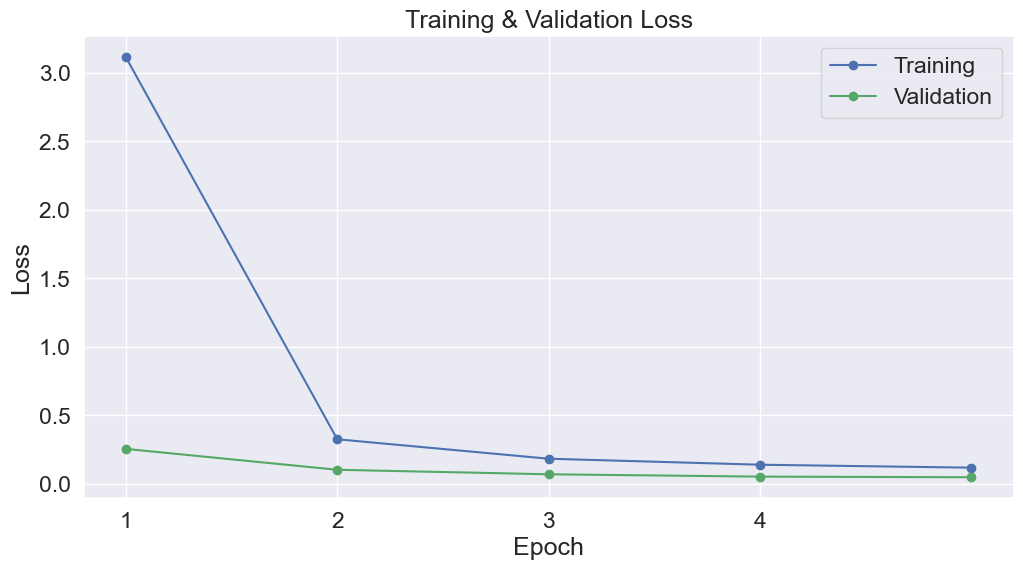

In [17]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [18]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The T5 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The T5 model has 131 different named parameters.

==== Embedding Layer ====

shared.weight                                           (32100, 512)
encoder.block.0.layer.0.SelfAttention.q.weight            (512, 512)

==== First Transformer ====

encoder.block.0.layer.0.SelfAttention.k.weight            (512, 512)
encoder.block.0.layer.0.SelfAttention.v.weight            (512, 512)
encoder.block.0.layer.0.SelfAttention.o.weight            (512, 512)
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight      (32, 8)
encoder.block.0.layer.0.layer_norm.weight                     (512,)
encoder.block.0.layer.1.DenseReluDense.wi.weight         (2048, 512)
encoder.block.0.layer.1.DenseReluDense.wo.weight         (512, 2048)
encoder.block.0.layer.1.layer_norm.weight                     (512,)
encoder.block.1.layer.0.SelfAttention.q.weight            (512, 512)
encoder.block.1.layer.0.SelfAttention.k.weight            (512, 512)
encoder.block.1.layer.0.SelfAttention.v.weight      

In [19]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_T5/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_T5.save_pretrained(output_dir)



Saving model to ./model_save_T5/


('./model_save_T5/tokenizer_config.json',
 './model_save_T5/special_tokens_map.json',
 './model_save_T5/spiece.model',
 './model_save_T5/added_tokens.json')

In [9]:
output_dir = './model_save_T5/'
model = T5ForConditionalGeneration.from_pretrained(output_dir).cuda()
tokenizer = T5Tokenizer.from_pretrained(output_dir)
device = torch.device("cuda")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
model.eval()

prompt = "<s> = Soap = :"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=100,
                                max_length = 100,
                                top_p=2,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

tensor([[   3,    2,    7, 3155, 3274,  264,    9,  102, 3274,    3,   10,    1]],
       device='cuda:0')
0: 


1: 


2: 




In [12]:
max_length = model.config.n_positions
stride = 512

def ppl(model, input_ids_all, stride):
  nlls = []
  for i in tqdm(range(0, input_ids_all.size(1), stride)):
      begin_loc = max(i + stride - max_length, 0)
      end_loc = min(i + stride, input_ids_all.size(1))
      trg_len = end_loc - i  # may be different from stride on last loop
      input_ids = input_ids_all[:, begin_loc:end_loc].to("cuda:0")
      target_ids = input_ids.clone()
      target_ids[:, :-trg_len] = -100

      with torch.no_grad():
          outputs = model(input_ids, labels=target_ids)
          neg_log_likelihood = outputs[0] * trg_len

      nlls.append(neg_log_likelihood)

  ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
  return ppl

In [13]:
encodings = tokenizer("\n\n".join(dealt_test), return_tensors="pt")
ppl(model, encodings.input_ids, stride)

Token indices sequence length is longer than the specified maximum sequence length for this model (5624 > 512). Running this sequence through the model will result in indexing errors


100%|██████████| 11/11 [00:00<00:00, 31.64it/s]


tensor(1.2947, device='cuda:0')